In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql import functions as F
import re
import matplotlib.pyplot as plt

# Run in all cores
SPARK_MASTER= "local[*]"
SPARK_APP_NAME= "dataframes"

# Spark session is the modern way to manage Spark and interact with the context.
spark_session = SparkSession.builder.master(SPARK_MASTER).appName(SPARK_APP_NAME).getOrCreate()

sc = spark_session.sparkContext
sc

your 131072x1 screen size is bogus. expect trouble
24/11/10 13:43:45 WARN Utils: Your hostname, PC-MAN resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/11/10 13:43:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/10 13:43:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/10 13:43:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


<SparkContext master=local[*] appName=dataframes>

In [2]:
rdd = sc.textFile("data/atussum.csv")

header = rdd.first()

# Remove header from RDD and split the remaining lines by commas
data_rdd = rdd.filter(lambda row: row != header).map(lambda row: row.split(","))

# Define schema manually
column_names = header.split(",")
schema = StructType([StructField(column_names[0], StringType(), False)] + 
                    [StructField(col, DoubleType(), False) for col in column_names[1:]])

# Convert RDD to DataFrame with the schema
df = spark_session.createDataFrame(data_rdd.map(lambda row: [row[0]] + [float(c) for c in row[1:]]), schema)


In [ ]:
primary_needs_pattern = "^t01\d+|^t03\d+|^t11\d+|^t1801\d+|^t1803\d+"
working_pattern = "^t05\d+|^t1805\d+"
leisure_pattern = "^t02\d+|^t04\d+|^t06\d+|^t07\d+|^t08\d+|^t09\d+|^t10\d+|^t12\d+|^t13\d+|^t14\d+|^t15\d+|^t16\d+|^t18\d+"

primary_needs_columns = [col for col in df.columns if re.match(primary_needs_pattern, col)]
working_columns = [col for col in df.columns if re.match(working_pattern, col)]
leisure_columns = [col for col in df.columns if re.match(leisure_pattern, col)]

primary_needs_columns, working_columns, leisure_columns
df = df.withColumn("primary_needs", sum(F.col(c) for c in primary_needs_columns)) \
    .withColumn("working", sum(F.col(c) for c in working_columns)) \
    .withColumn("leisure", sum(F.col(c) for c in leisure_columns))

df = df.select("telfs", "tesex", "teage", "primary_needs", "working", "leisure")

# Age category enum depending on age number.
df = df.withColumn("age_category",
    F.when(F.col("teage") < 22, "young")
     .when((F.col("teage") >= 22) & (F.col("teage") <= 55), "active")
     .otherwise("elderly")
)

df = df.withColumn("employed",
                    F.when((F.col("telfs") == 1) | (F.col("telfs") == 2), True)
                    .otherwise(False)
                   )

# Drop unused columns
df = df.drop("teage")
df = df.drop("telfs")

df.cache()

24/11/10 13:43:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[tesex: double, primary_needs: double, working: double, leisure: double, age_category: string, employed: boolean]

In [4]:
def getAverages(df):
    return df.agg(
        F.avg("primary_needs").alias("average_primary_needs"),
        F.avg("working").alias("average_working"),
        F.avg("leisure").alias("average_leisure")
        )


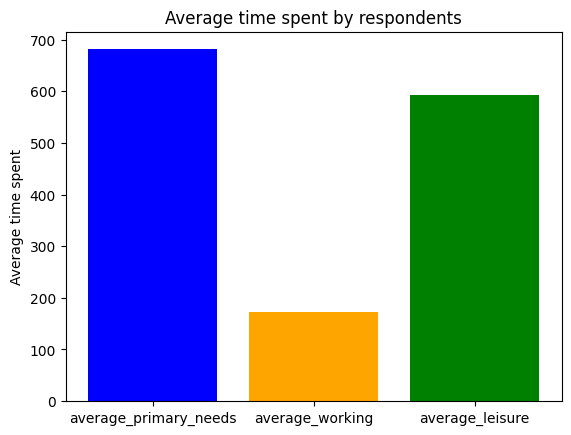

In [5]:
averages = getAverages(df)

pd_df = averages.toPandas()

categories = pd_df.columns
values = pd_df.iloc[0]

plt.title("Average time spent by respondents")
plt.bar(categories, values, color=['blue', 'orange', 'green'])
plt.ylabel("Average time spent")
plt.show()

### How much time do the respondents spend on primary needs compared to other activities?
Respondents spend the majority of their time on primary needs, followed by leisure activities. The least amount of time is dedicated to work.

### Getting the average time spend for men and women

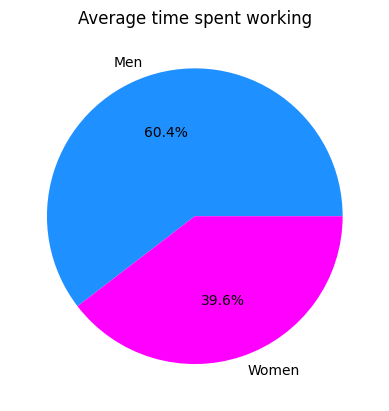

In [6]:
total_men = getAverages(df.filter(F.col("tesex") == 1))
total_women = getAverages(df.filter(F.col("tesex") == 2))

men_working = total_men.toPandas()["average_working"][0]
women_working = total_women.toPandas()["average_working"][0]

plt.title("Average time spent working")
plt.pie([men_working, women_working], labels=["Men", "Women"], autopct='%1.1f%%', colors=["Dodgerblue", "Magenta"])
plt.show()

### Do women and men spend the same amount of time in working?
Men on average spent more time working then women.

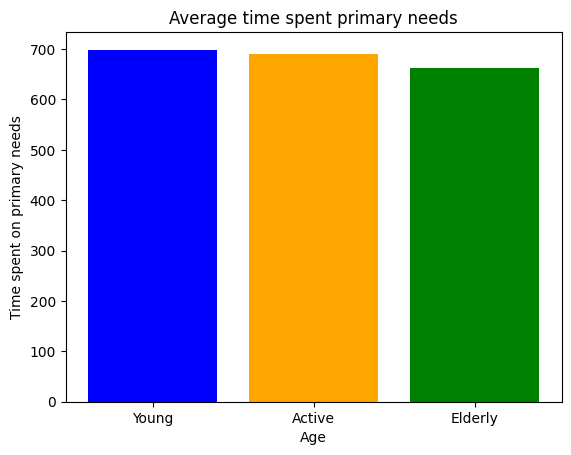

In [7]:
total_young = getAverages(df.filter(F.col("age_category") == "young"))
total_active = getAverages(df.filter(F.col("age_category") == "active"))
total_elderly = getAverages(df.filter(F.col("age_category") == "elderly"))

young_primary_needs = total_young.toPandas()["average_primary_needs"][0]
active_primary_needs = total_active.toPandas()["average_primary_needs"][0]
elderly_primary_needs = total_elderly.toPandas()["average_primary_needs"][0]

plt.title("Average time spent primary needs")
plt.bar(["Young", "Active", "Elderly"], [young_primary_needs, active_primary_needs, elderly_primary_needs], color=['blue', 'orange', 'green'])
plt.xlabel("Age")
plt.ylabel("Time spent on primary needs")
plt.show()

### Does the time spent on primary needs change when people get older?
On average it seems time spent on primary needs decreases a little with age.

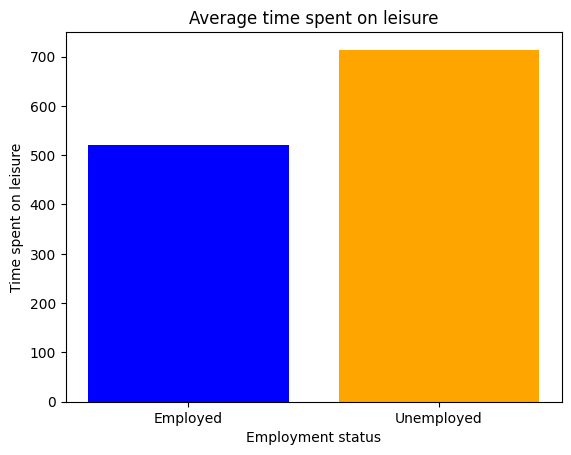

In [8]:
total_employed = getAverages(df.filter(F.col("employed") == True))
total_unemployed = getAverages(df.filter(F.col("employed") == False))


employed_leisure = total_employed.toPandas()["average_leisure"][0]
unemployed_leisure = total_unemployed.toPandas()["average_leisure"][0]

plt.title("Average time spent on leisure")
plt.bar(["Employed", "Unemployed"], [employed_leisure, unemployed_leisure], color=['blue', 'orange', 'green'])
plt.xlabel("Employment status")
plt.ylabel("Time spent on leisure")
plt.show()

In [9]:
spark_session.stop()